# Chapter 2: A real example. Importing data and setting series

## Data Management


In this example we will show how we can import data from a csv and generate a model with several depositional series.

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
%matplotlib inline

# Aux imports
import numpy as np


Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_ac0zkb68.c:4:19: fatal error: cudnn.h: No such file or directory\ncompilation terminated.\n'
Mapped name None to device cuda: GeForce GTX 1050 Ti (0000:01:00.0)


In this case instead loading a geo_data object directly, we will create one. The main atributes we need to pass are:
- Extent: X min, X max, Y min, Y max, Z min, Z max
- Resolution: X,Y,Z

Additionaly we can pass the address to csv files (GeoModeller3D format) with the data.

In [2]:
# Importing the data from csv files and settign extent and resolution
geo_data = gp.create_data([696000,747000,6863000,6930000,-20000, 200],[100, 100, 100],
                         path_o = os.pardir+"/input_data/a_Foliations.csv",
                         path_i = os.pardir+"/input_data/a_Points.csv")

You can visualize the points in 3D (work in progress)

Or a projection in 2D:

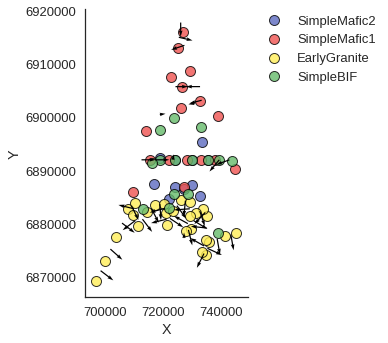

In [4]:
import matplotlib.pyplot as plt
gp.plot_data(geo_data, direction='z')


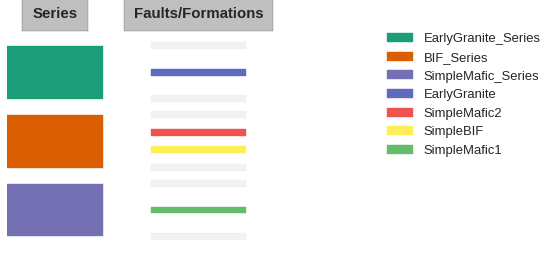

In [3]:
# Assigning series to formations as well as their order (timewise)
gp.set_series(geo_data, {"EarlyGranite_Series": 'EarlyGranite', 
                         "BIF_Series":('SimpleMafic2', 'SimpleBIF'),
                              "SimpleMafic_Series":'SimpleMafic1'}, 
                      order_series = ["EarlyGranite_Series",
                                      "BIF_Series",
                                      "SimpleMafic_Series"],
                      order_formations= ['EarlyGranite', 'SimpleMafic2', 'SimpleBIF', 'SimpleMafic1'],
              verbose=1)

## Computing the model

Now as in the previous chapter we just need to create the interpolator object and compute the model.

In [6]:
#geo_data = gp.select_series(geo_data, ['EarlyGranite_Series'])

In [4]:
interp_data = gp.InterpolatorData(geo_data, theano_optimizer='fast_run', compile_theano=True, verbose=[])

Compiling theano function...


/home/miguel/anaconda3/lib/python3.6/site-packages/theano/gpuarray/linalg.py:119: UserWarning: The GpuSolve op requires scikit-cuda > 0.5.1 to work with CUDA 8
  warnings.warn('The GpuSolve op requires scikit-cuda > 0.5.1 to work with CUDA 8')
/home/miguel/anaconda3/lib/python3.6/site-packages/theano/gpuarray/linalg.py:119: UserWarning: The GpuSolve op requires scikit-cuda > 0.5.1 to work with CUDA 8
  warnings.warn('The GpuSolve op requires scikit-cuda > 0.5.1 to work with CUDA 8')


Compilation Done!
Level of Optimization:  fast_run
Device:  cuda
Precision:  float32


In [8]:
new_grid = gp.GridClass()
res =  100

# Create a new grid object with the new resolution
new_grid.create_regular_grid_3d(geo_data.extent,[res, res, res])

# Setting the new grid to the geodata
gp.set_grid(geo_data, new_grid)

interp_data.update_interpolator(geo_data)

In [7]:
lith_block, fault_block = gp.compute_model(interp_data)

In [8]:
interp_data.th_fn.profile.summary()

Function profiling
  Message: ../../gempy/interpolator.py:124
  Time in 1 calls to Function.__call__: 7.347081e-01s
  Time in Function.fn.__call__: 7.346373e-01s (99.990%)
  Time in thunks: 7.345088e-01s (99.973%)
  Total compile time: 1.353186e+01s
    Number of Apply nodes: 150
    Theano Optimizer time: 5.968991e+00s
       Theano validate time: 3.187013e-02s
    Theano Linker time (includes C, CUDA code generation/compiling): 7.547253e+00s
       Import time 1.181498e-01s
       Node make_thunk time 7.538407e+00s
           Node forall_inplace,gpu,Looping interfaces}(Elemwise{Composite{minimum(minimum(minimum(minimum(minimum(minimum(i0, i1), i2), i3), i4), i5), i6)}}.0, GpuElemwise{add,no_inplace}.0, GpuElemwise{add,no_inplace}.0, GpuElemwise{add,no_inplace}.0, GpuElemwise{add,no_inplace}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64


Timing Info
-----------
--> <time> <% time> - <total time> <% total time>'

<time>         computation time for this node
<% time>       fraction of total computation time for this node
<total time>   time for this node + total times for this node's ancestors
<% total time> total time for this node over total computation time

N.B.:
* Times include the node time and the function overhead.
* <total time> and <% total time> may over-count computation times
  if inputs to a node share a common ancestor and should be viewed as a
  loose upper bound. Their intended use is to help rule out potential nodes
  to remove when optimizing a graph because their <total time> is very low.

HostFromGpu(gpuarray) [id A] <TensorType(float32, matrix)> ''   149 --> 3.58e-03s  0.5% 7.44e-01s 101.3%
 |GpuSubtensor{int64, ::, :int64:} [id B] <GpuArrayType<None>(float32, matrix)> ''   147 --> 3.10e-06s  0.0% 7.40e-01s 100.8%
   |forall_inplace,gpu,Looping interfaces}.0 [id C] <GpuArrayType<None>(float32, 3D)


Scan overhead:
<Scan op time(s)> <sub scan fct time(s)> <sub scan op time(s)> <sub scan fct time(% scan op time)> <sub scan op time(% scan op time)> <node>
        0.7s    1.4s    1.4s  198.4%  197.9% forall_inplace,gpu,Looping interfaces}(Elemwise{Composite{minimum(minimum(minimum(minimum(minimum(minimum(i0, i1), i2), i3), i4), i5), i6)}}.0, GpuElemwise{add,no_inplace}.0, GpuElemwise{add,no_inplace}.0, GpuElemwise{add,no_inplace}.0, GpuElemwise{add,no_inplace}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuIncSubtensor{InplaceSet;:int64:}.0, Elemwise{Composite{minimum(minimum(minimum(minimum(minimum(minimum(i0, i1), i2), i3), i4), i5), i6)}}.0, Coordinates of the grid points to interpolate, GpuFromHost<None>.0, GpuFromHost<None>.0, GpuFromHost<None>.0, GpuFromHost<None>.0, <GpuArrayT

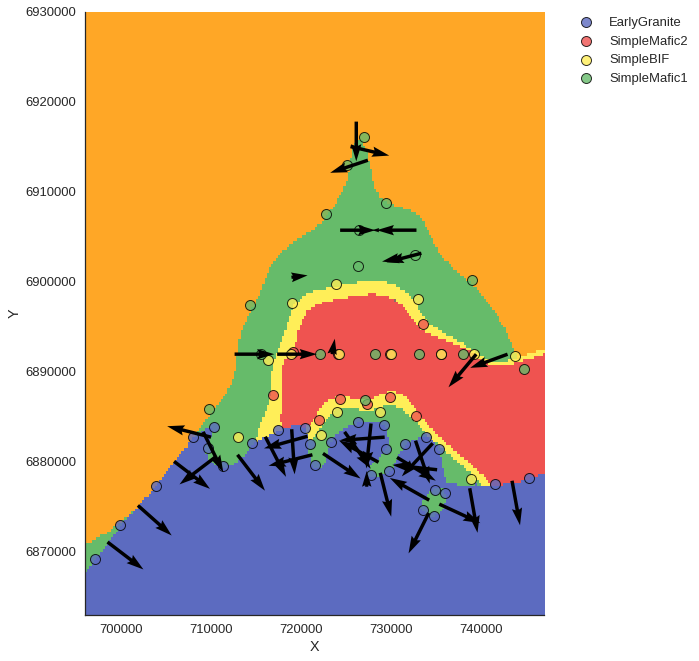

In [17]:
import matplotlib.pyplot as plt

gp.plot_section(geo_data, lith_block[0], -2, plot_data=True, direction='z')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [11]:
np.unique(lith_block[0])

array([ 0.,  1.,  2.,  3.,  4.], dtype=float32)

In [13]:
interp_data.th_fn.profile.summary()

Function profiling
  Message: ../../gempy/interpolator.py:124
  Time in 1 calls to Function.__call__: 7.283313e-01s
  Time in Function.fn.__call__: 7.282755e-01s (99.992%)
  Time in thunks: 7.281694e-01s (99.978%)
  Total compile time: 1.815800e+01s
    Number of Apply nodes: 150
    Theano Optimizer time: 5.949651e+00s
       Theano validate time: 3.639269e-02s
    Theano Linker time (includes C, CUDA code generation/compiling): 1.219025e+01s
       Import time 1.330874e-01s
       Node make_thunk time 1.218366e+01s
           Node forall_inplace,gpu,Looping interfaces}(Elemwise{Composite{minimum(minimum(minimum(minimum(minimum(minimum(i0, i1), i2), i3), i4), i5), i6)}}.0, GpuElemwise{add,no_inplace}.0, GpuElemwise{add,no_inplace}.0, GpuElemwise{add,no_inplace}.0, GpuElemwise{add,no_inplace}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64


Timing Info
-----------
--> <time> <% time> - <total time> <% total time>'

<time>         computation time for this node
<% time>       fraction of total computation time for this node
<total time>   time for this node + total times for this node's ancestors
<% total time> total time for this node over total computation time

N.B.:
* Times include the node time and the function overhead.
* <total time> and <% total time> may over-count computation times
  if inputs to a node share a common ancestor and should be viewed as a
  loose upper bound. Their intended use is to help rule out potential nodes
  to remove when optimizing a graph because their <total time> is very low.

HostFromGpu(gpuarray) [id A] <TensorType(float32, matrix)> ''   149 --> 1.73e-03s  0.2% 7.37e-01s 101.1%
 |GpuSubtensor{int64, ::, :int64:} [id B] <GpuArrayType<None>(float32, matrix)> ''   147 --> 3.10e-06s  0.0% 7.35e-01s 100.9%
   |forall_inplace,gpu,Looping interfaces}.0 [id C] <GpuArrayType<None>(float32, 3D)


Scan overhead:
<Scan op time(s)> <sub scan fct time(s)> <sub scan op time(s)> <sub scan fct time(% scan op time)> <sub scan op time(% scan op time)> <node>
        0.7s    1.5s    1.5s  202.9%  202.3% forall_inplace,gpu,Looping interfaces}(Elemwise{Composite{minimum(minimum(minimum(minimum(minimum(minimum(i0, i1), i2), i3), i4), i5), i6)}}.0, GpuElemwise{add,no_inplace}.0, GpuElemwise{add,no_inplace}.0, GpuElemwise{add,no_inplace}.0, GpuElemwise{add,no_inplace}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuSubtensor{int64:int64:int64}.0, GpuIncSubtensor{InplaceSet;:int64:}.0, Elemwise{Composite{minimum(minimum(minimum(minimum(minimum(minimum(i0, i1), i2), i3), i4), i5), i6)}}.0, Coordinates of the grid points to interpolate, GpuFromHost<None>.0, GpuFromHost<None>.0, GpuFromHost<None>.0, GpuFromHost<None>.0, <GpuArrayT

Now if we analyse the results we have a 3D array where the axis 0 represent the superposition of the series (potential fields). The color coding is working process yet.

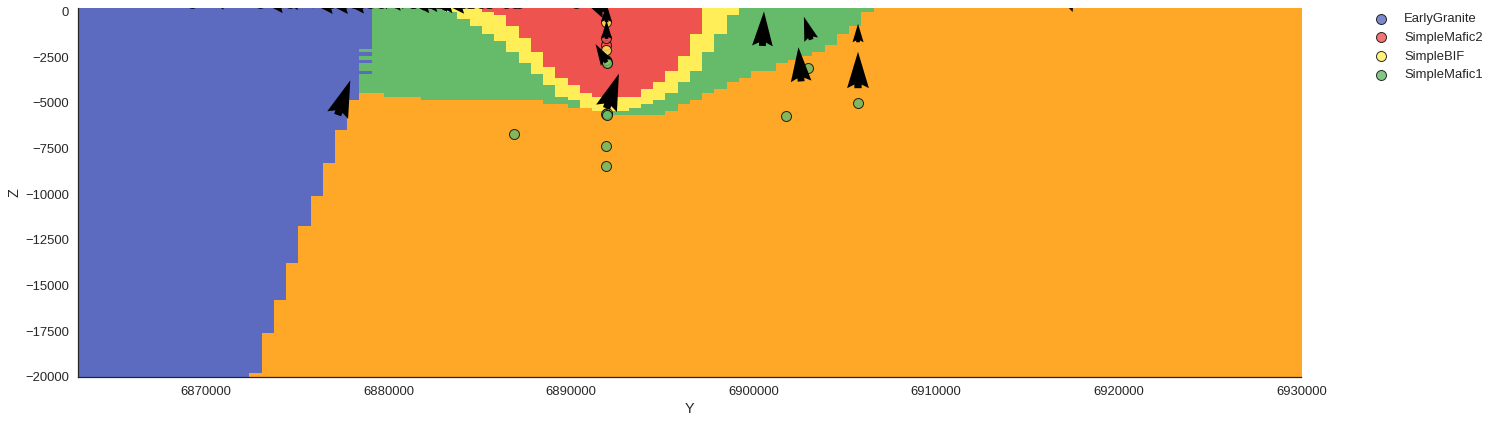

In [33]:
%matplotlib inline
gp.plot_section(geo_data, lith_block[0],50, plot_data=True, direction='x')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

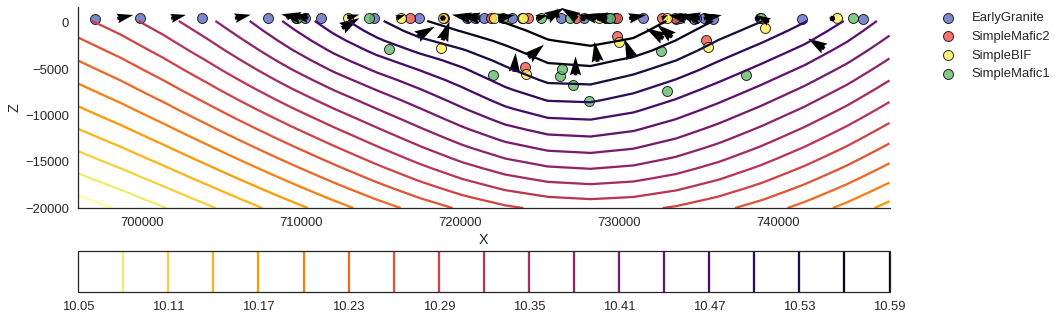

In [10]:
gp.plot_scalar_field(geo_data, lith_block[1], 11, cmap='inferno_r', N=20)
import matplotlib.pyplot as plt
plt.colorbar(orientation='horizontal')

And the axis 2 keeps the faults network that in this model since there is not faults does not represent anything.

Additionally with can export the blocks to vtk in order to visualize them in Paraview. We are working in visualization in place as well.

In [ ]:
vertices, simplices = gp.get_surfaces(interp_data, lith_block[1], None, original_scale=False)

# np.save('ver_sand', vertices)
# np.save('sim_sand', simplices)

In [ ]:
gp.export_to_vtk(geo_data, lith_block=lith_block[0], vertices=vertices, simplices=simplices)

In [ ]:
gp.plot_surfaces_3D_real_time(interp_data, vertices, simplices, alpha=1)